
|평가문항|상세기준|
|:--|:--|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 구축

In [3]:
(ds_train, ds_val, ds_test), info = tfds.load(
    'stanford_dogs',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

In [4]:
#train, val, test 개수 확인
len(ds_train),len(ds_val),len(ds_test)

(10800, 1200, 8580)

In [5]:
# class 확인
num_classes = info.features["label"].num_classes
num_classes

120

In [7]:
info.features["label"]

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

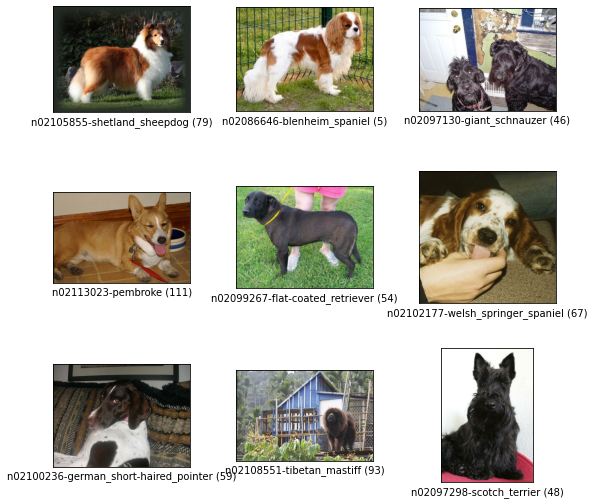

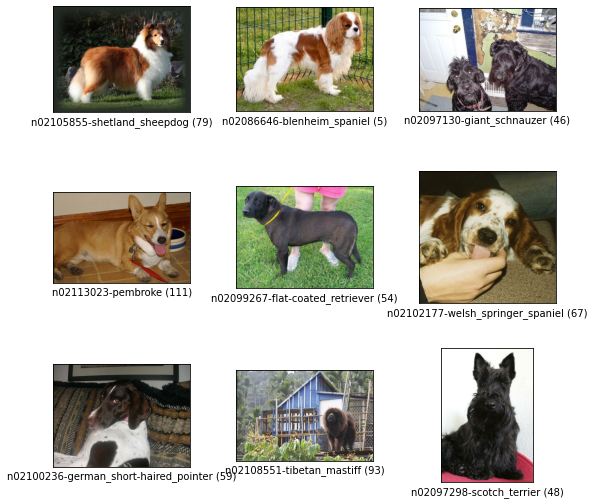

In [8]:
tfds.show_examples(ds_train, info)

### 데이터 확인

In [9]:
sample = ds_train.take(1)

In [12]:
smp_img, smp_y = None, None
for s in sample: 
    smp_img = s[0]
    smp_y = s[1]
    print()
smp_y

<tf.Tensor: shape=(), dtype=int64, numpy=99>

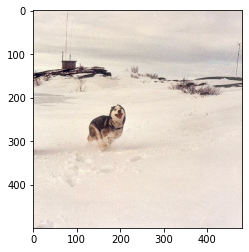

In [13]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(smp_img))

In [14]:
import math

In [10]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
#     print('augment')
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def augment2(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.image.random_contrast(image, 1/1.3, 1.3)
    image = tf.image.random_hue(image, 0.1)
#     image = tf.keras.preprocessing.image.random_rotation(image, 90)

#     random_height = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
#     random_width = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
#     image = tf.image.resize(image, (random_height, random_width))
#     image = tf.image.random_crop(image, (32, 32, 3))
    return image, label

In [16]:
def plot_aug(col,row,aug, img, y):
    plt.figure(0, figsize=(15, 15))
    plots = []
    for i in range(row):
        for j in range(col):
            image, label = normalize_and_resize_img(img, y)
            image, label = aug(img, y)
            image = tf.keras.preprocessing.image.array_to_img(image)
            ax = plt.subplot2grid((row,col), (i,j))
            ax.imshow(image)
    plt.show() 

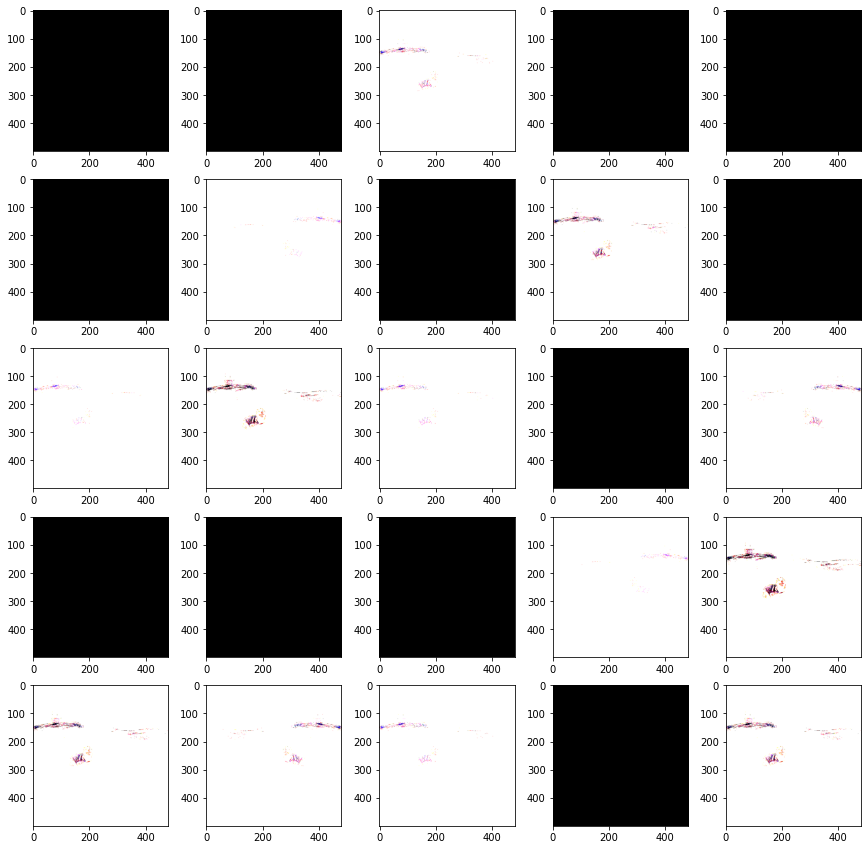

In [17]:
plot_aug(5, 5, augment, smp_img, smp_y)

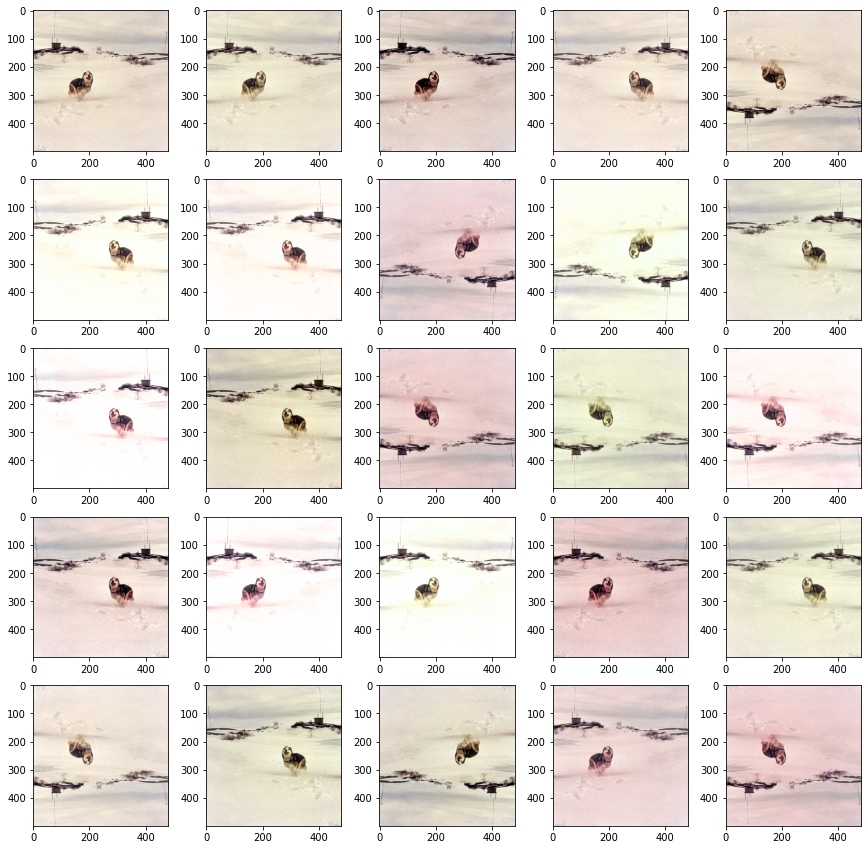

In [18]:
plot_aug(5, 5, augment2, smp_img, smp_y)

### 전처리

In [11]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # 일반 aug 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)
    
    # cutmix, mixup은 batch 후에 적용
    # cutmix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup 적용
    elif not is_test and with_mixup:  
        ds = ds.map(
            mixup,
            num_parallel_calls=2)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
            
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_val = apply_normalize_on_dataset(ds_val, is_test=False)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### CutMix

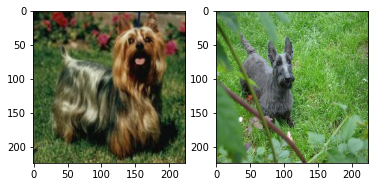

In [13]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [14]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(18, shape=(), dtype=int32) tf.Tensor(204, shape=(), dtype=int32)
y :  tf.Tensor(21, shape=(), dtype=int32) tf.Tensor(149, shape=(), dtype=int32)


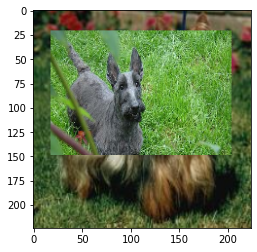

In [15]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [16]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.4744898, 0.       , 0.5255102, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [17]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

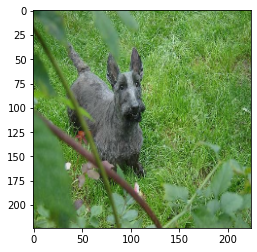

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.87075865 0.         0.12924135 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [18]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [19]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 모델 구축

In [20]:
# base resnet-50 사용
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
EPOCH = 20 

### (1) Resnet-50

In [32]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 170s 212ms/step - loss: 2.1470 - accuracy: 0.4689 - val_loss: 3.0560 - val_accuracy: 0.2601
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 0.6228 - accuracy: 0.8332 - val_loss: 1.0811 - val_accuracy: 0.6712
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 0.1846 - accuracy: 0.9668 - val_loss: 0.9683 - val_accuracy: 0.6959
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0541 - accuracy: 0.9955 - val_loss: 0.9299 - val_accuracy: 0.7186
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0323 - accuracy: 0.9981 - val_loss: 0.9343 - val_accuracy: 0.7181
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0175 - accuracy: 0.9993 - val_loss: 0.9325 - val_accuracy: 0.7288
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0121 - accuracy: 0.9998 - val_loss: 0.9567 -

In [34]:
del ds_train_no_aug

In [33]:
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_no_aug.hdf5')
del resnet50
print('Resnet-50 plain')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

537/537 [==============================] - 26s 49ms/step - loss: 1.0354 - accuracy: 0.7386


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Resnet-50 plain
Loss: 1.0354243516921997,
Accuracy: 0.7385780811309814


In [35]:
import pickle

In [36]:
with open('history_resnet50_no_aug.pickle','wb') as f:
    pickle.dump(history_resnet50_no_aug.history,f)
    
del history_resnet50_no_aug

### (2) Resnet-50 with general augmentation

In [37]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

In [38]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 211ms/step - loss: 2.8656 - accuracy: 0.3041 - val_loss: 3.1356 - val_accuracy: 0.2274
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 1.5281 - accuracy: 0.5672 - val_loss: 1.6298 - val_accuracy: 0.5219
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 1.0499 - accuracy: 0.6985 - val_loss: 1.3603 - val_accuracy: 0.5843
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.7401 - accuracy: 0.7901 - val_loss: 1.2690 - val_accuracy: 0.6311
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 0.5266 - accuracy: 0.8487 - val_loss: 1.6105 - val_accuracy: 0.5810
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.3823 - accuracy: 0.8984 - val_loss: 1.4989 - val_accuracy: 0.5974
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.2960 - accuracy: 0.9229 - val_loss: 1.5871 -

In [39]:
del ds_train_aug
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_aug.hdf5')

print('Resnet-50 with aug')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

with open('history_resnet50_aug.pickle','wb') as f:
    pickle.dump(history_resnet50_aug.history,f)
    
# del history_resnet50_aug
# del resnet50

537/537 [==============================] - 26s 48ms/step - loss: 1.2241 - accuracy: 0.7110
Resnet-50 with aug
Loss: 1.2241010665893555,
Accuracy: 0.7109557390213013


In [35]:
del history_resnet50_aug
del resnet50

다른 aug : tutorials

In [40]:
del apply_normalize_on_dataset

In [41]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # 일반 aug 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    # cutmix, mixup은 batch 후에 적용
    # cutmix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup 적용
    elif not is_test and with_mixup:  
        ds = ds.map(
            mixup,
            num_parallel_calls=2)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
            
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds



In [42]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

In [43]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug2 = resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 211ms/step - loss: 2.2589 - accuracy: 0.4386 - val_loss: 2.6787 - val_accuracy: 0.3115
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 0.8774 - accuracy: 0.7533 - val_loss: 1.4557 - val_accuracy: 0.5740
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 0.4327 - accuracy: 0.8869 - val_loss: 1.0368 - val_accuracy: 0.6849
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.2360 - accuracy: 0.9444 - val_loss: 1.0936 - val_accuracy: 0.6839
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 0.1296 - accuracy: 0.9753 - val_loss: 0.9737 - val_accuracy: 0.7179
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0707 - accuracy: 0.9892 - val_loss: 1.0056 - val_accuracy: 0.7201
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0395 - accuracy: 0.9952 - val_loss: 1.0444 -

In [44]:
del ds_train_aug
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_aug2.hdf5')

print('Resnet-50 with aug2')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

with open('history_resnet50_aug2.pickle','wb') as f:
    pickle.dump(history_resnet50_aug2.history,f)
    
del history_resnet50_aug2
del resnet50

537/537 [==============================] - 27s 50ms/step - loss: 1.0373 - accuracy: 0.7392
Resnet-50 with aug2
Loss: 1.0372589826583862,
Accuracy: 0.7391608357429504


### (3) Resnet-50 with cutmix

In [22]:
ds_train_cm = apply_normalize_on_dataset(ds_train, with_cutmix=True)

In [23]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cm = resnet50.fit(
    ds_train_cm, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 209s 203ms/step - loss: 3.7658 - accuracy: 0.2245 - val_loss: 3.7615 - val_accuracy: 0.1747
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 2.8873 - accuracy: 0.4509 - val_loss: 1.4143 - val_accuracy: 0.5996
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5913 - accuracy: 0.5500 - val_loss: 1.4757 - val_accuracy: 0.5925
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3373 - accuracy: 0.6299 - val_loss: 1.3723 - val_accuracy: 0.5992
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2255 - accuracy: 0.6666 - val_loss: 1.1965 - val_accuracy: 0.6728
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.1085 - accuracy: 0.7136 - val_loss: 1.4870 - val_accuracy: 0.5926
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0010 - accuracy: 0.7399 - val_loss: 1.2485 -

시간 관계상 같은 조원이 같은 조건으로 돌린 모델을 사용  
아래는 그 모델의 학습 로그 캡쳐

![image](./cm_evaluate.png)

In [27]:
# del ds_train_cm
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_cm.hdf5')

print('Resnet-50 with Cutmix')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

import pickle 

with open('history_resnet50_cm.pickle','wb') as f:
    pickle.dump(history_resnet50_cm.history,f)
    
del history_resnet50_cm
del resnet50

537/537 [==============================] - 26s 47ms/step - loss: 1.5244 - accuracy: 0.6478
Resnet-50 with Cutmix
Loss: 1.5243546962738037,
Accuracy: 0.6477855443954468


### (4) Resnet-50 with mixup

In [29]:
ds_train_mu = apply_normalize_on_dataset(ds_train, with_mixup=True)

In [30]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mu = resnet50.fit(
    ds_train_mu, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 208ms/step - loss: 3.7029 - accuracy: 0.2470 - val_loss: 3.9335 - val_accuracy: 0.1304
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 2.8426 - accuracy: 0.4890 - val_loss: 1.4897 - val_accuracy: 0.5808
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.5377 - accuracy: 0.6028 - val_loss: 1.5601 - val_accuracy: 0.5466
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3461 - accuracy: 0.6760 - val_loss: 1.3652 - val_accuracy: 0.6240
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2364 - accuracy: 0.7228 - val_loss: 1.6204 - val_accuracy: 0.5626
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.1292 - accuracy: 0.7603 - val_loss: 1.2945 - val_accuracy: 0.6371
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0583 - accuracy: 0.7875 - val_loss: 1.3152 -

In [31]:
del ds_train_mu
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_mu.hdf5')

print('Resnet-50 with MixUp')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

537/537 [==============================] - 27s 49ms/step - loss: 1.3780 - accuracy: 0.6690
Resnet-50 with MixUp
Loss: 1.3779624700546265,
Accuracy: 0.6689976453781128


In [33]:
with open('history_resnet50_mu.pickle','wb') as f:
    pickle.dump(history_resnet50_mu.history,f) # 이름 잘 못 저장했었음
    
del history_resnet50_mu
del resnet50

### 결과 비교 분석

In [34]:
import pickle
import matplotlib.pyplot as plt

In [36]:
with open('history_resnet50_no_aug.pickle', 'rb') as f:
    history_resnet50_no_aug = pickle.load(f) 
with open('history_resnet50_aug.pickle', 'rb') as f:
    history_resnet50_aug = pickle.load(f) 
with open('history_resnet50_cm.pickle', 'rb') as f:
    history_resnet50_cm = pickle.load(f) 
with open('history_resnet50_mu.pickle', 'rb') as f:
    history_resnet50_mu = pickle.load(f) 

In [37]:
histories = [
    history_resnet50_no_aug,
    history_resnet50_aug,
    history_resnet50_cm,
    history_resnet50_mu
]

In [38]:
names = ['Resnet-50','Augment','CutMix','MixUp']
# names = ['Resnet-50','Aug','MixUp']

In [39]:
colors = ['g','brown','b','deeppink']
lines = ['solid','dashed']

In [99]:
def show_log(metric, histories, names, each = False, valid = True):
    if each :
        fig, ax = plt.subplots(1,len(histories), figsize=(23,5))
        
        ax[0].plot(range(len(histories[0][metric])), histories[0][metric], color = colors[0], linestyle = lines[0], label = names[0])
        ax[0].plot(range(len(histories[0]['val_'+metric])), histories[0]['val_'+metric], color = colors[0], linestyle = lines[1], label = 'valid')
        ax[0].set_title(names[0])
        ax[0].legend()
        ax[1].plot(range(len(histories[1][metric])), histories[1][metric], color = colors[1], linestyle = lines[0], label = names[1])
        ax[1].plot(range(len(histories[1]['val_'+metric])), histories[1]['val_'+metric], color = colors[1], linestyle = lines[1], label = 'valid')
        ax[1].legend()
        ax[1].set_title(names[1])
        ax[2].plot(range(len(histories[2][metric])), histories[2][metric], color = colors[2], linestyle = lines[0], label = names[2])
        ax[2].plot(range(len(histories[2]['val_'+metric])), histories[2]['val_'+metric], color = colors[2], linestyle = lines[1], label = 'valid')
        ax[2].set_title(names[2])
        ax[2].legend()
        ax[3].plot(range(len(histories[3][metric])), histories[3][metric], color = colors[3], linestyle = lines[0], label = names[3])
        ax[3].plot(range(len(histories[3]['val_'+metric])), histories[3]['val_'+metric], color = colors[3], linestyle = lines[1], label = 'valid')
        ax[3].set_title(names[2])
        ax[3].legend()
        plt.suptitle(f'Training and Validation Log for {metric}')
        
    else :
        if metric == 'both':
            
            fig, ax = plt.subplots(1,2, figsize=(20,8))
            fig.suptitle('Training Log')
            
            ax[0].plot(range(len(histories[0]['loss'])), histories[0]['loss'],color = colors[0], linestyle = lines[0], label = names[0])
            ax[0].plot(range(len(histories[1]['loss'])), histories[1]['loss'],color = colors[1], linestyle = lines[0], label = names[1])
            ax[0].plot(range(len(histories[2]['loss'])), histories[2]['loss'],color = colors[2], linestyle = lines[0], label = names[2])
            ax[0].plot(range(len(histories[3]['loss'])), histories[3]['loss'],color = colors[3], linestyle = lines[0], label = names[3])
            
            ax[1].plot(range(len(histories[0]['accuracy'])), histories[0]['accuracy'],color = colors[0], linestyle = lines[0], label = names[0])
            ax[1].plot(range(len(histories[1]['accuracy'])), histories[1]['accuracy'],color = colors[1], linestyle = lines[0], label = names[1])
            ax[1].plot(range(len(histories[2]['accuracy'])), histories[2]['accuracy'],color = colors[2], linestyle = lines[0], label = names[2])
            ax[1].plot(range(len(histories[3]['accuracy'])), histories[3]['accuracy'],color = colors[3], linestyle = lines[0], label = names[3])
            
            if valid :
                ax[0].plot(range(len(histories[0]['loss'])), histories[0]['val_loss'],color = colors[0], linestyle = lines[1], label = 'val_'+names[0])
                ax[0].plot(range(len(histories[1]['loss'])), histories[1]['val_loss'],color = colors[1], linestyle = lines[1], label = 'val_'+names[1])
                ax[0].plot(range(len(histories[2]['loss'])), histories[2]['val_loss'],color = colors[2], linestyle = lines[1], label = 'val_'+names[2])
                ax[0].plot(range(len(histories[3]['loss'])), histories[3]['val_loss'],color = colors[3], linestyle = lines[1], label = 'val_'+names[3])
                
                ax[1].plot(range(len(histories[0]['accuracy'])), histories[0]['val_accuracy'],color = colors[0], linestyle = lines[1], label = 'val_'+names[0])
                ax[1].plot(range(len(histories[1]['accuracy'])), histories[1]['val_accuracy'],color = colors[1], linestyle = lines[1], label = 'val_'+names[1])
                ax[1].plot(range(len(histories[2]['accuracy'])), histories[2]['val_accuracy'],color = colors[2], linestyle = lines[1], label = 'val_'+names[2])
                ax[1].plot(range(len(histories[3]['accuracy'])), histories[3]['val_accuracy'],color = colors[3], linestyle = lines[1], label = 'val_'+names[3])
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].set_title('Accuracy')
            ax[1].legend()
        else:
            plt.figure(figsize=(4,4))
            plt.plot(range(len(histories[0][metric])), histories[0][metric],color = colors[0], linestyle = lines[0], label = names[0])
            plt.plot(range(len(histories[1][metric])), histories[1][metric],color = colors[1], linestyle = lines[0], label = names[1])
            plt.plot(range(len(histories[2][metric])), histories[2][metric],color = colors[2], linestyle = lines[0], label = names[2])
            plt.plot(range(len(histories[3][metric])), histories[3][metric],color = colors[3], linestyle = lines[0], label = names[3])
            plt.title(f'Training Log for: {metric}')

            if (metric != 'both') and valid:
                plt.plot(range(len(histories[0]['val_'+metric])), histories[0]['val_'+metric], color = colors[0], linestyle = lines[1], label = 'val_'+names[0])
                plt.plot(range(len(histories[1]['val_'+metric])), histories[1]['val_'+metric], color = colors[1], linestyle = lines[1], label = 'val_'+names[1])
                plt.plot(range(len(histories[2]['val_'+metric])), histories[2]['val_'+metric], color = colors[2], linestyle = lines[1], label = 'val_'+names[2])
                plt.plot(range(len(histories[3]['val_'+metric])), histories[3]['val_'+metric], color = colors[3], linestyle = lines[1], label = 'val_'+names[3])



    plt.legend()       
    plt.show()

In [100]:
def Compare_log(title, history1, history2 , names, valid = True):
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    
    fig.suptitle(title, fontsize = 15)
    ax[0].plot(range(len(history1['loss'])), history1['loss'], color = colors[0], linestyle = lines[0],label = names[0])
    ax[0].plot(range(len(history2['loss'])), history2['loss'], color = colors[1], linestyle = lines[0],label = names[1])
    if valid :
        ax[0].plot(range(len(history1['val_loss'])), history1['val_loss'], color = colors[0], linestyle = lines[1],label = 'val_'+names[0])
        ax[0].plot(range(len(history2['val_loss'])), history2['val_loss'], color = colors[1], linestyle = lines[1],label = 'val_'+names[1])
        ax[0].set_title('Training and Validation Loss')
    else: 
        ax[0].set_title('Training Loss')  
    ax[0].legend()


    ax[1].plot(range(len(history1['accuracy'])), history1['accuracy'], color = colors[0], linestyle = lines[0],label = names[0])
    ax[1].plot(range(len(history2['accuracy'])), history2['accuracy'], color = colors[1], linestyle = lines[0],label = names[1])
    if valid :
        ax[1].plot(range(len(history1['accuracy'])),history1['val_accuracy'], color = colors[0], linestyle = lines[1],label = 'val_'+names[0])
        ax[1].plot(range(len(history2['accuracy'])),history2['val_accuracy'], color = colors[1], linestyle = lines[1],label = 'val_'+names[1])
        ax[1].set_title('Training and Validation Accuracy')
    else:
        ax[1].set_title('Training Loss')  
    ax[1].legend()
    plt.show()

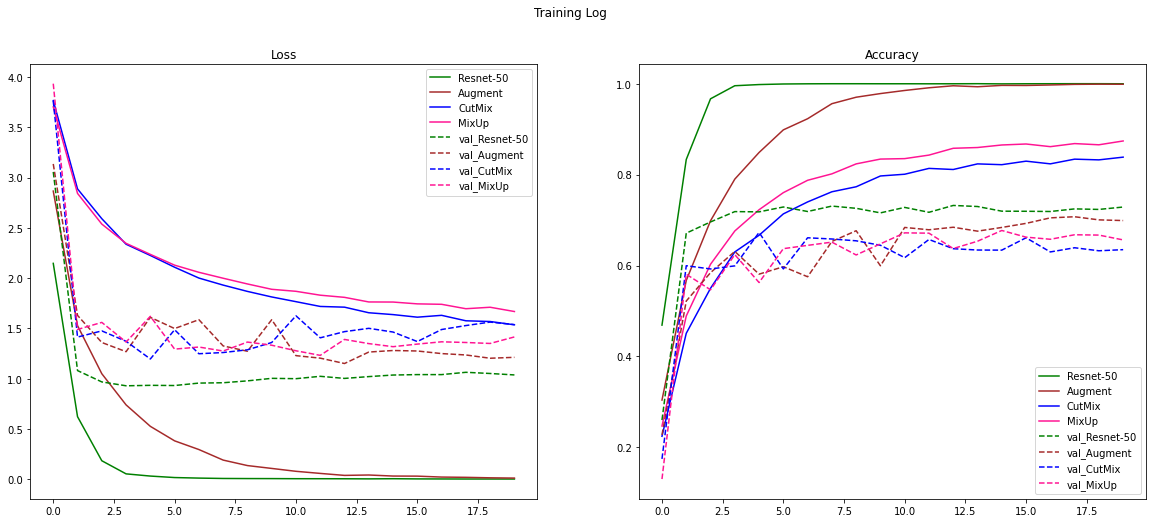

In [107]:
show_log('both', histories, names, each = False, valid = True)

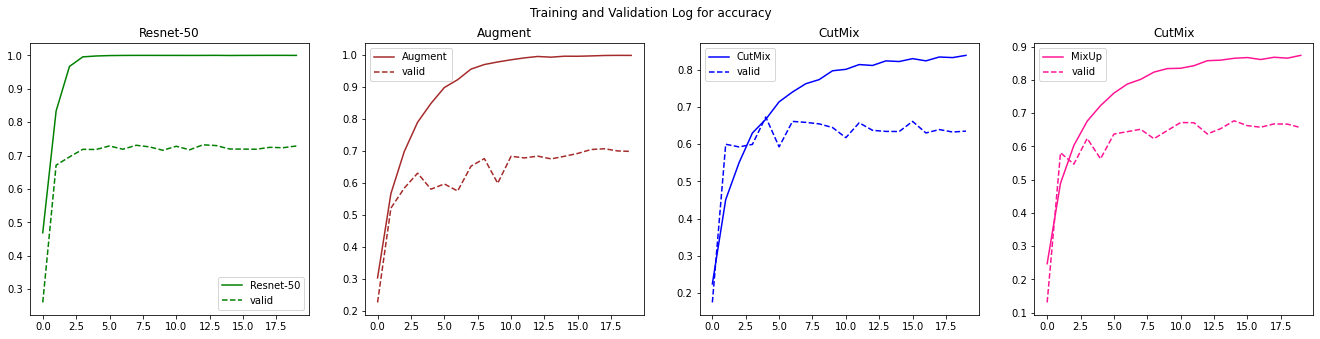

In [108]:
show_log('accuracy', histories, names, each = True)

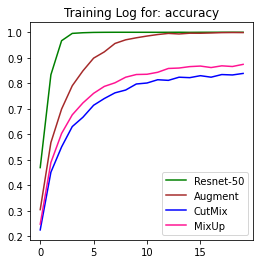

In [109]:
show_log('accuracy', histories, names, each = False, valid = False)

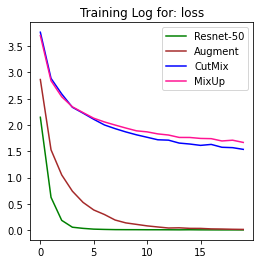

In [110]:
show_log('loss', histories, names, each = False, valid = False)

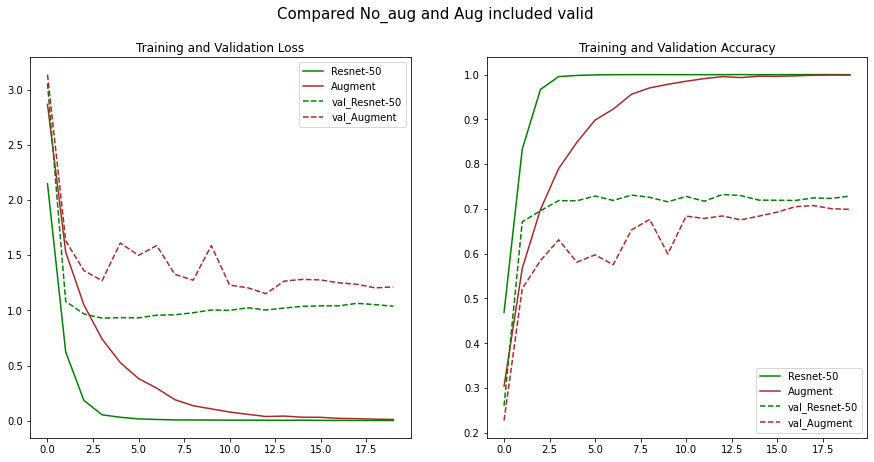

In [111]:
Compare_log('Compared No_aug and Aug included valid',history_resnet50_no_aug, history_resnet50_aug , names)

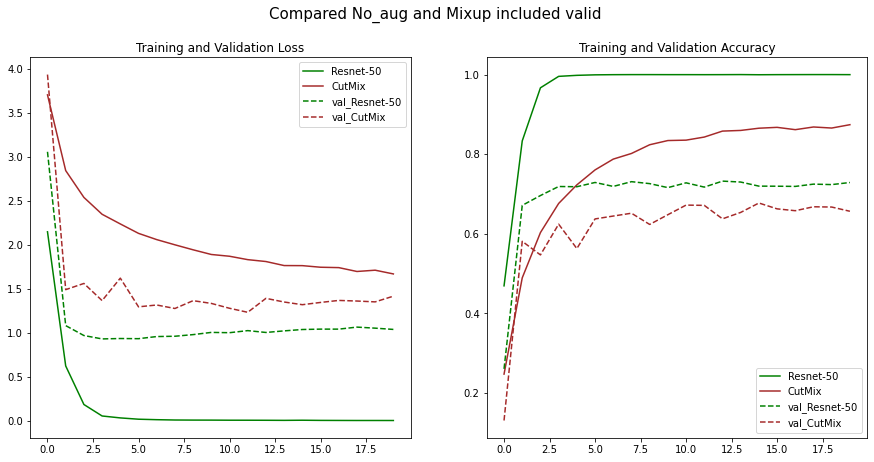

In [112]:
 Compare_log('Compared No_aug and Mixup included valid',history_resnet50_no_aug, history_resnet50_mu , [names[0],names[2]])

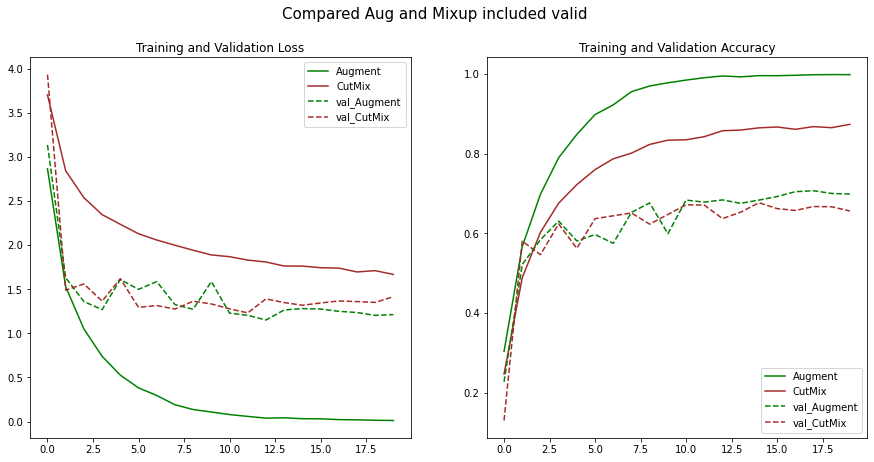

In [113]:
Compare_log('Compared Aug and Mixup included valid',history_resnet50_aug, history_resnet50_mu , [names[1],names[2]])

## 회고

- CutMix와 MixUp 기법을 ResNet50에 적용시킨 결과:

-> cutmix 기법 (test_acc : 0.66) [mixup test_acc : 0.59]  


- 이 task를 하는데 최적인 augmentation 기법:
    
mixup은 accuracy가 약 0.59인 반면 cutmix를 사용했을 때 0.66이 나왔기 때문에 이 작업을 하는 데에는 cutmix가 더 낫습니다. 
그러나 plain보다 더 낮은 성적을 가지고 있기 때문에 지금의 augmentation 방법이 최적은 아닌 것 같습니다. 



- 기법을 달리 함으로써 달라지는 결과 분석:
    
적합한 데이터셋 혹은 기법이 제대로 작동했는지에 대한 점검이 필요하다. 



### ++추가(additional 결과들에 대한 회고)

1. 최적 augmentation방법은 찾기 힘듦
2. validation loss의 경우엔 cutmix와 mixup 예시들을 확인했을 때, label과 image가 혼란스러운 경우가 있어서 train 데이터를 맞추기는 힘들고 깔끔한 사진인 validation을 맞추기 쉬워서 발생하는 것으로 보임.. 그렇다고 accuracy가 높은 건 아니어서 그 부분은 잘 모르겠음 (overfii